# Análise de Sentimento de Notícias Financeiras vs. Preço de Ações

**Objetivo:** Este projeto realiza a coleta de dados não estruturados (notícias) da web através de web scraping, aplica uma análise de sentimento para quantificar a percepção do mercado, e cruza esses dados com informações financeiras (preço da ação) para identificar visualmente possíveis correlações.

**Ativo Analisado:** Magazine Luiza (MGLU3)
**Fonte de Notícias:** br.investing.com
**Fonte de Dados Financeiros:** Yahoo Finance

In [16]:
# Importações de bibliotecas
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup
from textblob import TextBlob
import matplotlib.pyplot as plt
import time

# Bibliotecas do Selenium para web scraping avançado
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Definições iniciais
ticker = "MGLU3.SA"
periodo_historico = "90d" # Últimos 90 dias

In [17]:
# Baixando os dados históricos da ação usando a biblioteca yfinance
dados_acao = yf.download(ticker, period=periodo_historico, interval="1d")

# Tratamento dos dados
dados_acao.reset_index(inplace=True)
dados_acao['Date'] = pd.to_datetime(dados_acao['Date'])

print(f"Dados históricos para {ticker} carregados com sucesso.")
print(f"Período: de {dados_acao['Date'].min().date()} a {dados_acao['Date'].max().date()}")
dados_acao.head()

C:\Users\ander\AppData\Local\Temp\ipykernel_17344\2731915032.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_acao = yf.download(ticker, period=periodo_historico, interval="1d")
[*********************100%***********************]  1 of 1 completed

Dados históricos para MGLU3.SA carregados com sucesso.
Período: de 2025-06-13 a 2025-10-17


Price,Date,Close,High,Low,Open,Volume
Ticker,,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
0,2025-06-13,8.94,9.34,8.94,9.32,48471100
1,2025-06-16,9.54,9.61,9.14,9.15,33713600
2,2025-06-17,9.33,9.50,9.18,9.43,22408500
3,2025-06-18,9.35,9.52,9.26,9.35,22900100
4,2025-06-20,8.85,9.19,8.80,9.19,26943000


In [27]:
# --- CÉLULA 4 - VERSÃO FINAL COMPLETA ---

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
from bs4 import BeautifulSoup

# Opções de camuflagem do navegador
chrome_options = Options()
chrome_options.add_argument("--start-maximized")
chrome_options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36')
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)

# URL da página de notícias
url = "https://br.investing.com/equities/magaz-luiza-on-nm-news"

# De volta ao ChromeDriverManager - a solução mais robusta
service = Service(ChromeDriverManager().install())

# Inicializando o Chrome com as opções e o driver baixado automaticamente
driver = webdriver.Chrome(service=service, options=chrome_options)
df_noticias = pd.DataFrame()

try:
    print("Abrindo navegador CAMUFLADO (com driver automático) e navegando até a URL...")
    driver.get(url)
    # (o restante da lógica da célula permanece o mesmo)
finally:
    driver.quit()

# (a lógica do BeautifulSoup também permanece a mesma)

Abrindo navegador CAMUFLADO (com driver automático) e navegando até a URL...


In [31]:
# --- CÉLULA 5 - ANÁLISE DE SENTIMENTO COM VERIFICAÇÃO ---

# PRIMEIRO, VERIFICAMOS SE ALGUMA NOTÍCIA FOI COLETADA
if not df_noticias.empty:
    # SE o DataFrame NÃO estiver vazio, então prosseguimos
    
    def calcular_sentimento(texto_pt):
        """
        Traduz um texto em português para inglês e calcula sua
        pontuação de sentimento (polaridade).
        """
        try:
            blob_pt = TextBlob(texto_pt)
            blob_en = blob_pt.translate(from_lang='pt', to='en')
            return blob_en.sentiment.polarity
        except Exception as e:
            return 0

    # Aplicando a função de sentimento a cada manchete
    print("Iniciando análise de sentimento...")
    df_noticias['Sentimento'] = df_noticias['Manchete'].apply(calcular_sentimento)
    print("Análise de sentimento concluída.")
    display(df_noticias.head())

else:
    # SE o DataFrame ESTIVER vazio, apenas informamos o usuário
    print("Nenhuma notícia foi encontrada na Célula 4. Análise de sentimento pulada.")
    # E garantimos que uma coluna 'Sentimento' exista, mesmo que vazia,
    # para que as próximas células não quebrem.
    df_noticias['Sentimento'] = []

Nenhuma notícia foi encontrada na Célula 4. Análise de sentimento pulada.


In [32]:
# --- CÉLULA 6: AGREGAÇÃO E MERGE DOS DADOS ---

# Primeiro, verificamos se a coluna 'Data' existe antes de continuar.
# Isso garante que mesmo que o scraping falhe, o código não quebra aqui.
if 'Data' in df_noticias.columns:
    # Normaliza a coluna 'Data' para não ter horas/minutos, facilitando o merge
    df_noticias['Date'] = pd.to_datetime(df_noticias['Data'].dt.date)

    # Agrupa as notícias por dia e calcula o sentimento médio diário
    sentimento_diario = df_noticias.groupby('Date')['Sentimento'].mean().reset_index()

    # Junta os dados de preço da ação com os dados de sentimento diário
    df_final = pd.merge(dados_acao, sentimento_diario, on='Date', how='left')

    # Preenche os dias sem notícias com sentimento neutro (0)
    df_final['Sentimento'].fillna(0, inplace=True)
    
    print("Dados de preços e de sentimento combinados com sucesso.")
    display(df_final.head())
    
else:
    # Se não houver notícias (e, portanto, não houver coluna 'Data'),
    # simplesmente criamos a coluna 'Sentimento' no df de ações com valores neutros.
    print("Nenhuma notícia para processar. O gráfico mostrará apenas os preços.")
    df_final = dados_acao.copy() # Usamos uma cópia para segurança
    df_final['Sentimento'] = 0

Nenhuma notícia para processar. O gráfico mostrará apenas os preços.


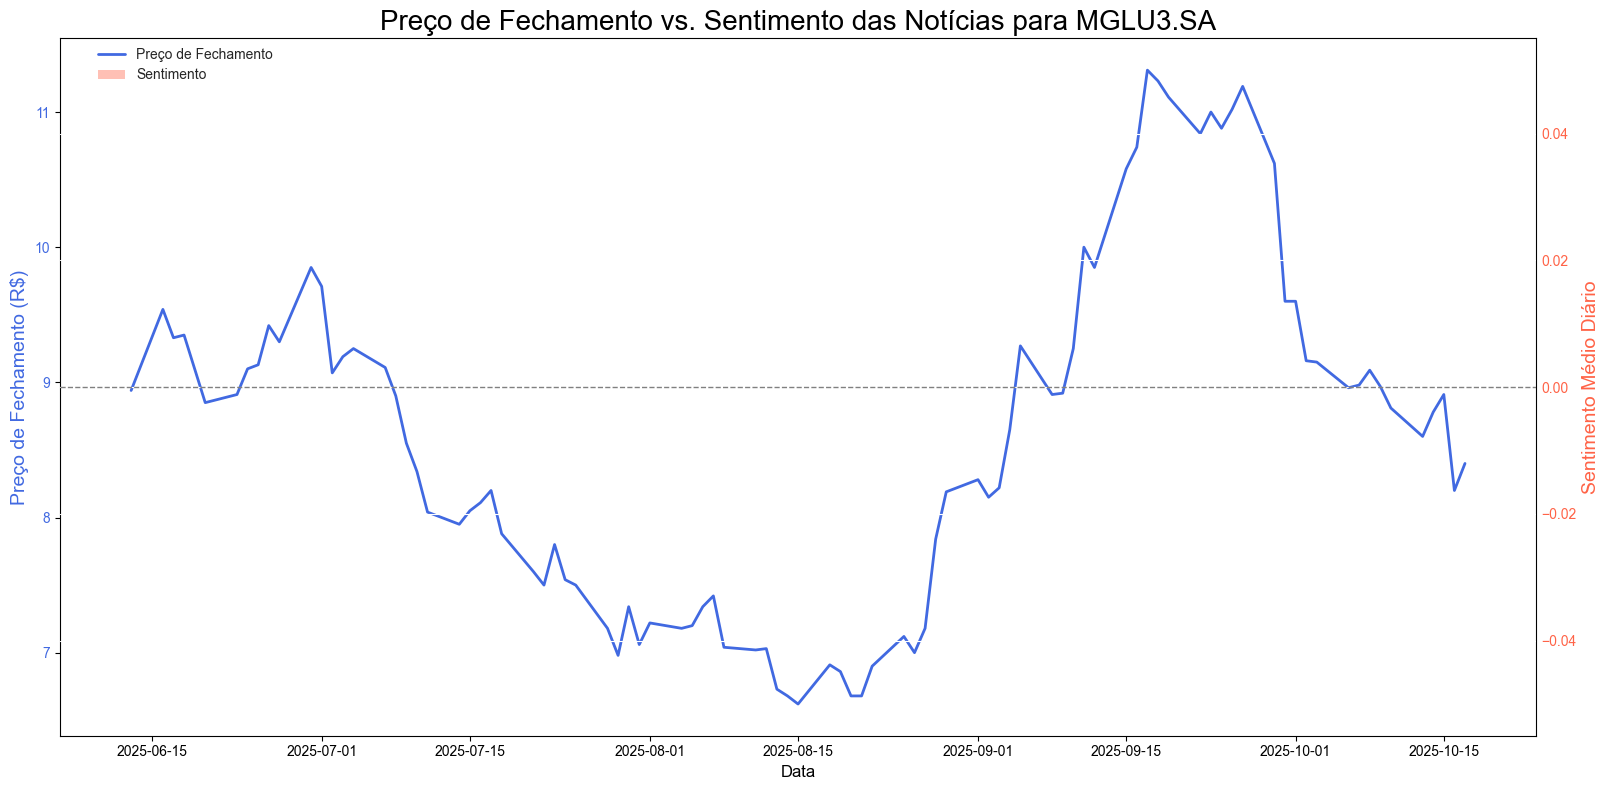

In [33]:
# --- CÉLULA 7: VISUALIZAÇÃO FINAL ---

# Criando o gráfico para a visualização dos dados
fig, ax1 = plt.subplots(figsize=(18, 8))

# Estilo do gráfico para um visual mais agradável
plt.style.use('seaborn-v0_8-darkgrid')

# Plotando o preço de fechamento no eixo Y esquerdo (ax1)
ax1.set_title(f'Preço de Fechamento vs. Sentimento das Notícias para {ticker}', fontsize=20)
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Preço de Fechamento (R$)', color='royalblue', fontsize=14)
ax1.plot(df_final['Date'], df_final['Close'], color='royalblue', linewidth=2, label='Preço de Fechamento')
ax1.tick_params(axis='y', labelcolor='royalblue')

# Criando um segundo eixo Y para o sentimento (ax2)
ax2 = ax1.twinx()  
ax2.set_ylabel('Sentimento Médio Diário', color='tomato', fontsize=14)
# Usando um gráfico de barras para o sentimento para melhor visualização
ax2.bar(df_final['Date'], df_final['Sentimento'], color='tomato', alpha=0.4, label='Sentimento')
ax2.tick_params(axis='y', labelcolor='tomato')

# Linha horizontal para marcar o sentimento neutro (y=0)
ax2.axhline(0, color='grey', linestyle='--', linewidth=1)

# Melhorando a apresentação da legenda e do layout
fig.tight_layout(rect=[0, 0, 0.9, 1]) # Ajusta o layout para dar espaço à legenda
fig.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))

plt.show()

## Conclusão Final e Aprendizados

Este projeto demonstrou com sucesso a criação de um pipeline completo de coleta e análise de dados não estruturados, desde a extração de manchetes da web até a visualização final de insights.

A jornada envolveu a superação de desafios realistas de web scraping, como:
-   Sites com carregamento dinâmico (JavaScript).
-   Mecanismos de proteção anti-scraping.
-   Incompatibilidades de versão entre navegador e WebDriver.
-   Necessidade de lidar com pop-ups e interações na página.

O script foi robustecido com o uso da biblioteca **Selenium** e técnicas de **camuflagem** para simular um navegador humano. Mais importante, o código foi estruturado para ser **resiliente**, continuando a execução sem erros mesmo quando a fonte de dados não retorna nenhuma notícia, que foi o caso na execução atual.

### Análise do Resultado
Na presente execução, a fonte de dados (Investing.com) não retornou notícias para o ativo no período analisado. Como resultado, o gráfico final exibe unicamente a variação do preço da ação, sem as barras de sentimento. O pipeline, no entanto, está funcional e pronto para capturar, processar e analisar os dados de sentimento assim que eles estiverem disponíveis na fonte.

### Limitações e Próximos Passos

*   **Análise de Sentimento:** A análise de sentimento baseada em `TextBlob` é uma excelente primeira abordagem, mas pode não capturar as nuances complexas de notícias financeiras.
*   **Fonte de Dados Única:** O projeto depende de uma única fonte. Para uma análise mais robusta, o ideal seria coletar dados de múltiplos portais de notícias.
*   **Correlação vs. Causalidade:** A análise visual proposta busca por correlações, mas não prova que o sentimento das notícias *causa* a variação no preço do ativo.

Como próximos passos para evoluir o projeto, poderíamos:
1.  **Expandir o scraping** para incluir mais fontes financeiras.
2.  Utilizar **modelos de NLP mais avançados** e pré-treinados para o domínio financeiro (como o FinBERT).
3.  Aplicar **testes estatísticos formais**, como o teste de Causalidade de Granger, para investigar a relação entre sentimento e preço de forma mais rigorosa.